In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Setting some variables

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Generators

In [3]:
# training set generator
train_gen = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\projects\\iNeuron\\computer_vision\\vegetable_images\\images\\train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15000 files belonging to 15 classes.


In [4]:
# Test set generator
test_gen = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\projects\\iNeuron\\computer_vision\\vegetable_images\\images\\test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 15 classes.


In [5]:
# Validation set generator
val_gen = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\projects\\iNeuron\\computer_vision\\vegetable_images\\images\\validation",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 15 classes.


In [6]:
class_names = train_gen.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [7]:
for image_batch, labels_batch in train_gen.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 4  5 14  4  0  4  0  8  7  5  3 11  9  3 12 14 14  2 12 10  5  5  8  3
 10  4 11  6  4  3  9  6]


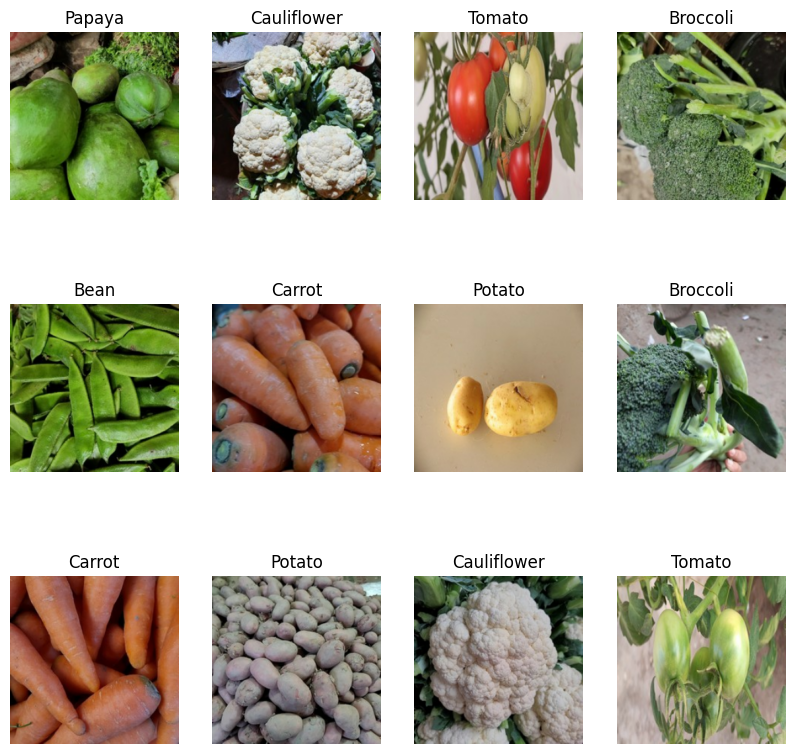

In [8]:
## Visualize some images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_gen.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
# Since we have already loaded data seperately for training, testing and valiation so we don't need to splid the dataset

## Cache, Shuffle and Prefetch the Dataset for better performance while training

In [10]:
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_gen = val_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_gen = test_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Defining a layer for resize and rescale

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
# Applying augmentation to the training set
train_gen = train_gen.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Defining the architecture of our CNN model

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [16]:
## Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
## Training the model 
history = model.fit(
    train_gen,
    batch_size=BATCH_SIZE,
    validation_data=val_gen,
    verbose=1,
    epochs=8,
)

Epoch 1/8
469/469 [==============================] - 1417s 3s/step - loss: 1.9280 - accuracy: 0.3055 - val_loss: 1.3997 - val_accuracy: 0.4953
Epoch 2/8
 36/469 [=>............................] - ETA: 10:02 - loss: 1.4105 - accuracy: 0.4905